# Statistical Learning.- Targetting Users

In [8]:
import numpy as np
import seaborn as sns
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt 
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, ConfusionMatrixDisplay, confusion_matrix, classification_report

In [9]:
PATH = '../../data/'
df_frame = pd.read_csv(PATH + 'feature_frame.csv', engine='pyarrow')
pd.set_option('display.max_columns', None)

**Filtramos el datase para obtener el dataset objetivo**

In [10]:
def filter_orders(data):
    order_counts = data.groupby('order_id')['outcome'].sum().reset_index(name='products_bought')
    filtered_orders = order_counts[order_counts['products_bought'] >= 5]
    final_dataframe = data[data['order_id'].isin(filtered_orders['order_id'])]
    return final_dataframe

df = filter_orders(data=df_frame)
print(df.head())
print('\n')
print("Número de filas:", df.shape[0])

       variant_id     product_type       order_id        user_id  \
0  33826472919172  ricepastapulses  2807985930372  3482464092292   
1  33826472919172  ricepastapulses  2808027644036  3466586718340   
2  33826472919172  ricepastapulses  2808099078276  3481384026244   
3  33826472919172  ricepastapulses  2808393957508  3291363377284   
5  33826472919172  ricepastapulses  2808434524292  3479090790532   

           created_at order_date  user_order_seq  outcome  ordered_before  \
0 2020-10-05 16:46:19 2020-10-05               3      0.0             0.0   
1 2020-10-05 17:59:51 2020-10-05               2      0.0             0.0   
2 2020-10-05 20:08:53 2020-10-05               4      0.0             0.0   
3 2020-10-06 08:57:59 2020-10-06               2      0.0             0.0   
5 2020-10-06 10:50:23 2020-10-06               3      0.0             0.0   

   abandoned_before  active_snoozed  set_as_regular  normalised_price  \
0               0.0             0.0             0.0    

In [11]:
print(df.columns)
nuemric = ['avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id','avg_days_to_buy_product_type','std_days_to_buy_product_type','normalised_price', 'discount_pct', 'global_popularity']
ordinal = ['user_order_seq', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id', 'days_since_purchase_product_type']
categrorical = ['product_type','outcome','ordered_before',
                'abandoned_before', 'active_snoozed', 'set_as_regular','vendor']
ides = ['order_id', 'user_id','variant_id']
date = ['created_at', 'order_date']

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')


In [12]:
df[ordinal] = df[ordinal].astype(np.int8)
df[['outcome', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']] = df[['outcome', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']].astype(np.int64)
df[nuemric] = df[nuemric].astype(np.float64)
df = df.drop(ides, axis=1)

/tmp/ipykernel_648/3402731855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ordinal] = df[ordinal].astype(np.int8)
/tmp/ipykernel_648/3402731855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['outcome', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']] = df[['outcome', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']].astype(np.int64)
/tmp/ipykernel_648/3402731855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Ya se comprobó en EDA pero de nuevo miraremos los null values

In [6]:
def count_null_values(df):
    null_counts = df.isna().sum()
    null_dict = null_counts.to_dict()
    return null_dict
count_null_values(df=df)

{'product_type': 0,
 'created_at': 0,
 'order_date': 0,
 'user_order_seq': 0,
 'outcome': 0,
 'ordered_before': 0,
 'abandoned_before': 0,
 'active_snoozed': 0,
 'set_as_regular': 0,
 'normalised_price': 0,
 'discount_pct': 0,
 'vendor': 0,
 'global_popularity': 0,
 'count_adults': 0,
 'count_children': 0,
 'count_babies': 0,
 'count_pets': 0,
 'people_ex_baby': 0,
 'days_since_purchase_variant_id': 0,
 'avg_days_to_buy_variant_id': 0,
 'std_days_to_buy_variant_id': 0,
 'days_since_purchase_product_type': 0,
 'avg_days_to_buy_product_type': 0,
 'std_days_to_buy_product_type': 0}

# Feature selection

En la anterior entrega no chequamos las correlaciones entre variables ordinale/categoricas. Primero mostraremos la correlacion entre las variables de descripcion familiar. 
Nos quedaremos con las variables 'count_babies' y 'people_ex_baby' ya que describen suficientemente bien la estructura familiar del cliente.

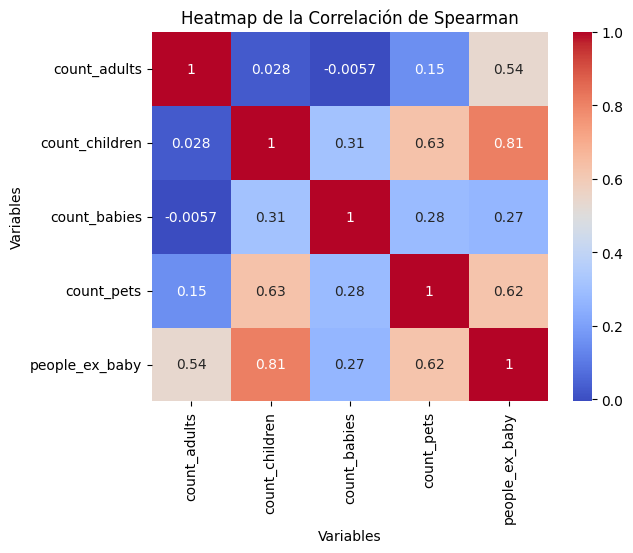

In [7]:
ppl_df = df[['count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby']]
correlation_matrix, _ = spearmanr(ppl_df)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=['count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby'], yticklabels=['count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby'])

plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Heatmap de la Correlación de Spearman')
plt.show()

In [13]:
df = df.drop(['count_adults', 'count_children', 'count_pets'], axis=1)

Tambien miraremos la correlacion de spearman de las variables days_to. Mantendremos todas las variables

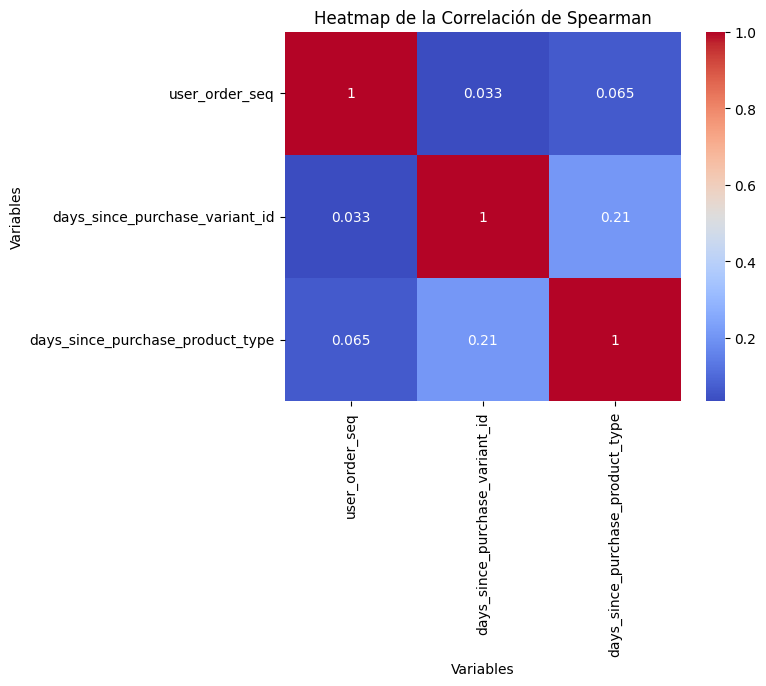

In [9]:
days_pd = df[['user_order_seq', 'days_since_purchase_variant_id', 'days_since_purchase_product_type']]
correlation_matrix, _ = spearmanr(days_pd)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=['user_order_seq', 'days_since_purchase_variant_id', 'days_since_purchase_product_type'], yticklabels=['user_order_seq', 'days_since_purchase_variant_id', 'days_since_purchase_product_type'])
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Heatmap de la Correlación de Spearman')
plt.show()

Ahora a las variabels categoricas

In [8]:
cat_df = df[categrorical].reset_index()

mapeo_banrio = {1: 'Si', 0:'No'}
cat_df['ordered_before'] = cat_df['ordered_before'].replace(mapeo_banrio)
cat_df['abandoned_before'] = cat_df['abandoned_before'].replace(mapeo_banrio)
cat_df['active_snoozed'] = cat_df['active_snoozed'].replace(mapeo_banrio)
cat_df['set_as_regular'] = cat_df['set_as_regular'].replace(mapeo_banrio)
 
Crosstab=pd.crosstab(index=df['vendor'],columns=df['product_type'])
ChiSqResult = chi2_contingency(Crosstab)
print('The P-Value of the ChiSq Test1 is:', ChiSqResult[1])

Crosstab=pd.crosstab(index=df['ordered_before'],columns=df['abandoned_before'])
ChiSqResult = chi2_contingency(Crosstab)
print('The P-Value of the ChiSq Test2 is:', ChiSqResult[1])

Crosstab=pd.crosstab(index=df['ordered_before'],columns=df['set_as_regular'])
ChiSqResult = chi2_contingency(Crosstab)
print('The P-Value of the ChiSq Test2 is:', ChiSqResult[1])

Crosstab=pd.crosstab(index=df['active_snoozed'],columns=df['abandoned_before'])
ChiSqResult = chi2_contingency(Crosstab)
print('The P-Value of the ChiSq Test2 is:', ChiSqResult[1])
 
# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

The P-Value of the ChiSq Test1 is: 0.0
The P-Value of the ChiSq Test2 is: 0.0
The P-Value of the ChiSq Test2 is: 0.0
The P-Value of the ChiSq Test2 is: 4.744305675762013e-86


Debemos mantener todas las variables categoricas/binarias segun el test chi-cuadrado. Muy probablemente debido a lo desbalanceados que estan. (Curiosisdad: si se explora la cross table vendor - product type, se observa que los vendedores son 'raramente' muy especialistas en el tipo de productos que proveen a la tienda. Puede que la categorizacion de product type sea poco generalista)

Sobre las variables numericas, se ha decidido eliminar las variables std_days_to... ya que esa informacion queda parcialmente recogida en su variable analoga avg_days_to y las correlaciones eran de >=0.30 (este paso es bastante cuestionable, pero elimina complejidad al modelo). Como ya se comentó, las variables ordinales presentan mucha variabilidad y sobre las variables estrictamente numericas, hay mas variabilidad en las referentes a items que no a product type (como es esperable). No se ha considerado necesario limpiar outliers (claros) ya que por lo general son outliers referetnes a productos que se compran con mucha frecuencia, relevantes y que aportaran info crucial al modelo (no eliminaremos outliers)

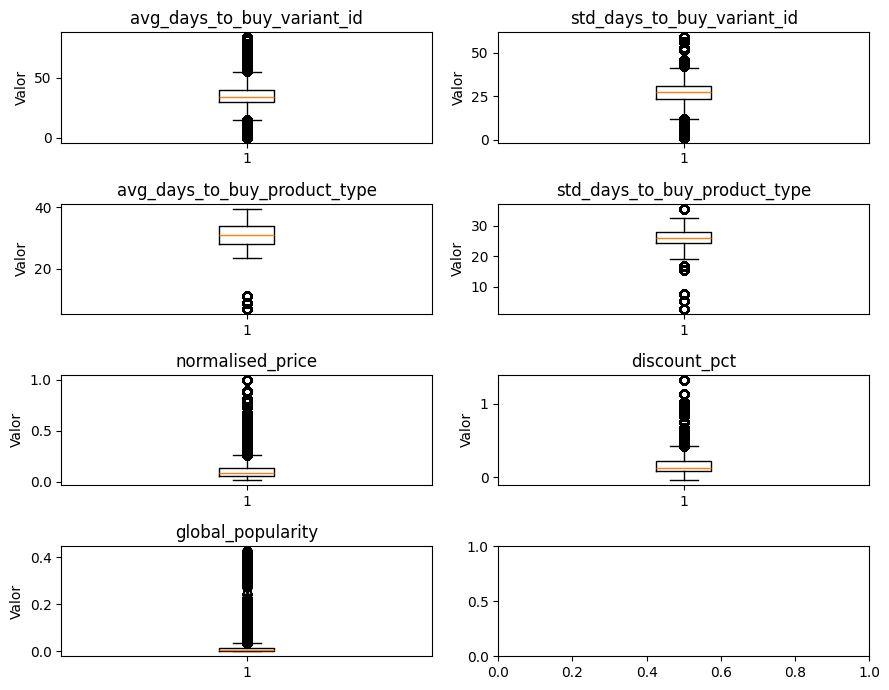

In [12]:
filas = (len(nuemric) + 1) // 2

fig, axes = plt.subplots(filas, 2, figsize=(9,7))
for i, cols in enumerate(nuemric):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.boxplot(df[cols])
    ax.set_title(f'{cols}')
    ax.set_ylabel('Valor')
plt.tight_layout()
plt.show()

In [14]:
df = df.drop(['std_days_to_buy_variant_id','std_days_to_buy_product_type'], axis=1)

Para hacer encoding de las variables categoricas 'product_type' y 'vendor', se ha usado Frequency encoding en vendor (ya que hay 264 categorias) y hot-encoding en product_type. Freq se realizará un vez establecidos los datos train-test para no perjudicar al overfitting del modelo

In [15]:
def encoder(df:pd.DataFrame, var:str) -> pd.DataFrame:
    encoder = OneHotEncoder(sparse=False, dtype=int, categories='auto', handle_unknown='ignore', max_categories=10)
    product_type_encoded = encoder.fit_transform(df[[var]])
    categories = encoder.get_feature_names_out()
    product_type_df = pd.DataFrame(product_type_encoded, columns=categories)#.reset_index(drop=True, inplace=True) 
    product_type_df.index = df.index
    encoded_df = pd.concat([df.drop(var, axis=1), product_type_df], axis=1)
    return encoded_df

df_encoded = encoder(df=df, var='product_type')

/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Nos quedaremos solo con la varible 'order_date' de las variables tipo Date (ausmiremos que no aporta info la hora del pedido) y crearemos tres columnas a partir de ella: Year, Month y Day_of_Year. Vimos en EDA que no habia estacionalidad en el timeline de orders, pero la varibale a solas 'day' estaría desvirtuando el momento de orden en el año 

In [16]:
df_encoded = df_encoded.drop(['created_at'], axis=1)

In [17]:
df_encoded['year'] = df_encoded['order_date'].dt.year
df_encoded['month'] = df_encoded['order_date'].dt.month
df_encoded['day_of_year'] = df_encoded['order_date'].dt.day_of_year
df_encoded = df_encoded.drop(['order_date'], axis=1)

Por último, ya que producto es una dimension clave de nuestro modelo y la variable presenta gran dispersion, discretizaremos la varible. Se ha considerado este metodo ya que mediante la frecuancia de compra podemos identificar tipos de productos (en un 'estrato' superior al product type) como productos regulares, mensuales o de consumo duraderos y dar interpretación al modelo.

(Bonus: en EDA vimos que las cuchillas de afeitar eran de los productos menos comprados. Una explicacion podría ser que es un producto que no se suele comprar habitualmente) 

In [18]:
def discretize_variable(df:pd.DataFrame, labels:list, variable:str) -> pd.DataFrame:
    discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
    df[variable] = discretizer.fit_transform(df[[variable]])
    df[variable] = df[variable].apply(lambda x: labels[int(x)])
    return df

labels = ['Weekly', 'Monthly', 'Yearly', 'Long_dur'] 

discretized_df = discretize_variable(df=df_encoded, labels=labels, variable='avg_days_to_buy_variant_id')
df_features = encoder(df=discretized_df, var='avg_days_to_buy_variant_id')

/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Train Test

Se ha establecido la relacion 70-15-15 para los subsets train-validation-test, que representan un total de 1.514.767 y 324.592 (x2) registros

In [19]:
# Features and target variable
X = df_features.drop(columns='outcome')
y = df_features['outcome']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42)

Vimos en EDA que las variables numericas no estaban reescaladas (ni normalizadas) y eso puede llegar a penalizar nuestro modelo. Además las escalas de las varaibles days_to, global_popularity y price son diferentes, lo que puede distorsionar la relevancia del pesa asignado a una de esas variables. Por lo que una vez spliteado el dataset, realizaremos dos ultimos pasos de preprocesado: el rescalado (StandardScaler) y un frecuancy encoding de la variable 'vendedor'.

In [20]:
def frequency_encoding(dataframe, column_name):
    frequencies = dataframe[column_name].value_counts(normalize=True)
    dataframe[column_name + '_encoded'] = dataframe[column_name].map(frequencies)
    dataframe = dataframe.drop([column_name], axis=1)
    return dataframe

In [21]:

X_val = frequency_encoding(X_val, 'vendor')
X_test = frequency_encoding(X_test, 'vendor')

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)
X_val_scaled = sc.transform(X_val)

Para le modelo estableceremos un pipeline de Sklearn (para ser mas escalable deberia incluirse la parte de preprocessing). Utilizaremos una LogisticRegression con saga como solver (eficiente para largos datasets y que permite aplicar regularizacion 'l1', 'l2', None y elasticnet). Haremos una malla de modelos con diferentes grados C de regularizacion y testearemos el AUC de todos los modelos en Validation para escoger el mejor.

In [18]:
# Paso 1: Definimos el pipeline
pipe = Pipeline([
    ('classifier', LogisticRegression(random_state=42, solver='saga'))
])

# Paso 2: Definimos parámetros (elasticnet es una combinacion de Lasso + Ridege, siendo Lasso l1 y Ridge l2)
param_grid = {
    'classifier__penalty': ['l1', 'l2', None],
    'classifier__C': [1e-6, 0.1, 1, 10]
}

# Paso 3: GridSearch con scoring 'accuracy' de la matriz de confusion
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs = -1, scoring='accuracy')
grid_search.fit(X_train, y_train)

/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ramon/Zrive/zrive-d

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [1e-06, 0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2', None]},
             scoring='accuracy')

In [6]:
#save your model or results
#joblib.dump(grid_search, 'model_file_name.pkl')
#load your model for further usage
#grid_search = joblib.load("model_file.pkl")

El ranking de modelos es el siguiente:

In [29]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
print(results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]].head())

                                                       params  \
kernel                                                          
0.1_l1      {'classifier__C': 0.1, 'classifier__penalty': ...   
0.1_l2      {'classifier__C': 0.1, 'classifier__penalty': ...   
1_l1        {'classifier__C': 1, 'classifier__penalty': 'l1'}   
1_l2        {'classifier__C': 1, 'classifier__penalty': 'l2'}   
1e-06_None  {'classifier__C': 1e-06, 'classifier__penalty'...   

            rank_test_score  mean_test_score  std_test_score  
kernel                                                        
0.1_l1                    1         0.985833        0.000054  
0.1_l2                    2         0.985833        0.000055  
1_l1                      3         0.985832        0.000056  
1_l2                      4         0.985831        0.000055  
1e-06_None                5         0.985831        0.000055  


In [23]:
# Muestra los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

Mejores hiperparámetros encontrados:
{'classifier__C': 0.1, 'classifier__penalty': 'l1'}


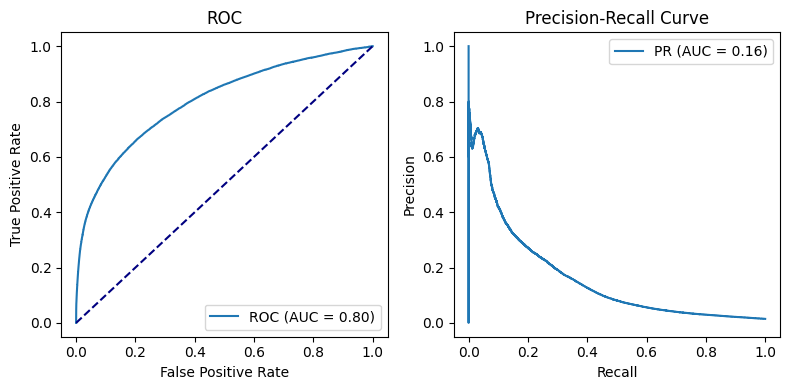

In [35]:
y_pred_prob = grid_search.predict_proba(X_train)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_train, y_pred_prob)

plt.figure(figsize=(8, 4))

# Curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# Curva de precisión-recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

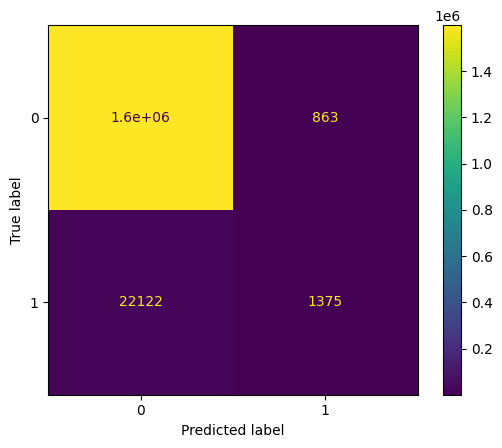

In [45]:
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_train, y_train)

El desbalance en la clase objetivo puede ser un desafío en la evaluación del modelo, ya que los modelos tienden a inclinarse hacia la clase dominante ("No compra"). El modelo ha generado 22122 falsos negativos, 863 falsos positivos y 1375 verdaderos positivos. Con una precision del 60%, el modelo secrifica (a un threshodl del 50%) muchas compras potenciales pero acierta notablemente en los clientes interesados en comprar.

- Curva ROC: La curva ROC es muy cercana a la esquina superior izquierda (crece muy rapido), lo que significa que el modelo es bueno para predecir la clase negativa ("No compra"). Si quermeos capturar más verdaderos positivos aumentan los falsos positivos (estmos dispuestos a ser más "intrusivos" con los correos electrónicos).

- Curva Precision-Recall: La precisión mide la proporción de verdaderos positivos entre todas las predicciones positivas, mientras que Recall (sensibilidad) mide la proporción de verdaderos positivos entre todas las instancias verdaderamente positivas. En un problema desbalanceado, queremos ajustar el threshold a un valor más alto (lo que aumentará la precisión pero disminuirá el recall) si deseas minimizar los falsos positivos y ser menos intrusivo. Vemos como al disminuir el recall la precision de nuestro modelo aumenta considerablemnte. El open rate es del 5%, un poco bajo, por lo que podría sacrificarse precision y el recall se mantendría aceptable. Esto dependerá del ratio de conversion de notificaciones en uninstalls de la aplicacion que considere negocio.

En el escenario de ser lo mas precisos posibles, podemos establecer un threshol del 80% para ser considerados como clase positiva

In [28]:
custom_threshold = 0.8

# Calculate probabilities for the positive class
y_cust_probs = grid_search.predict_proba(X_train)[:, 1]
y_cust_threshold = (y_cust_probs > custom_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_train, y_cust_threshold))

print("Confusion Matrix:")
print(confusion_matrix(y_train, y_cust_threshold))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1599467
           1       0.69      0.02      0.05     23497

    accuracy                           0.99   1622964
   macro avg       0.84      0.51      0.52   1622964
weighted avg       0.98      0.99      0.98   1622964

Confusion Matrix:
[[1599201     266]
 [  22915     582]]


La precision aumenta a un 70%. Podemos determinar que el modelo es muy conservador pero preciso, lo que es valorable si el coste de perdida por intrusion es alto. A continuacion trabajremos sobre Train los modelos para determinar el mejor. 

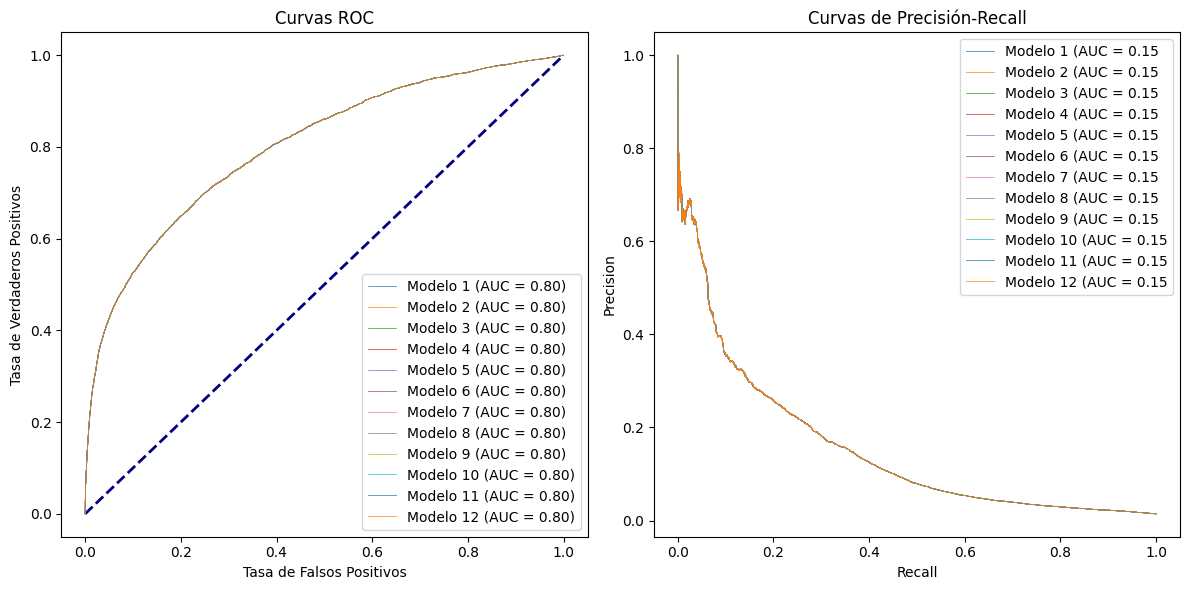

In [35]:
resultados = grid_search.cv_results_
plt.figure(figsize=(12, 6))

# Crear un gráfico para la curva ROC
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')

# Crear un gráfico para la curva de Recall-Precisión
plt.subplot(1, 2, 2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas de Precisión-Recall')

for i in range(len(resultados['params'])):
    modelo = grid_search.best_estimator_.set_params(**resultados['params'][i])
    y_pred_prob3 = modelo.predict_proba(X_val_scaled)[:, 1]
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob3)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, lw=0.5, label=f'Modelo {i+1} (AUC = {roc_auc:.2f})')

    # Curva de Recall-Precisión
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob3)
    pr_auc = auc(recall, precision)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, lw=0.5, label=f'Modelo {i+1} (AUC = {pr_auc:.2f}')


plt.subplot(1, 2, 1)
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Los modelos se comportan igual. Obtaermos por el default best_model de Sklearn (c=0.1, regularization = l1). Estudiaremos los coeficientes

<Axes: ylabel='Variables'>

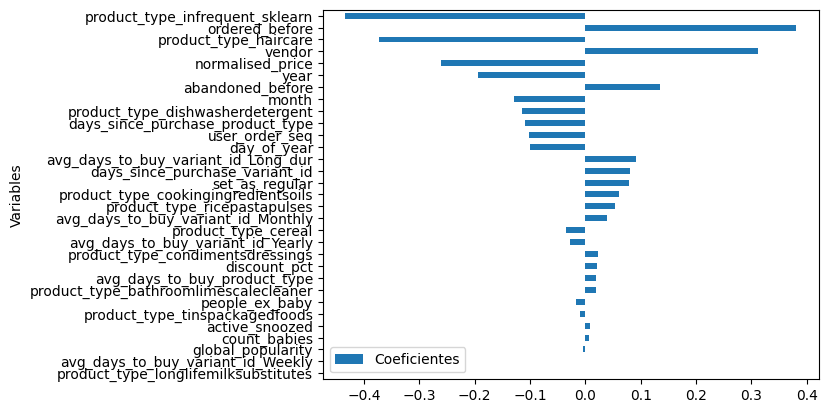

In [31]:
best_model = grid_search.best_estimator_
coefficients = best_model.named_steps['classifier'].coef_[0]
coefficients_df = pd.DataFrame({'Variables': X.columns, 'Coeficientes': coefficients})
coefficients_df = coefficients_df.reindex(coefficients_df['Coeficientes'].abs().sort_values(ascending=True).index)
coefficients_df.plot.barh(x='Variables', y='Coeficientes', rot=0)

La varibale que mas aporta son los tipos de productos 'menos relevantes' 'product_type_infrequent_sklearn' (es la categoria que agrupa al resto de productos que se quedan fuera del OneHot Encoding). Las variabels 'product_type_longlifemilksubstitutes' y 'avg_days_to_buy_variant_id_Weekly' ersultan no significativas. La interpretacion de los coeficeintes de una regresion logisitca es mediante los ODDS Ratio (ya que se usa Log() como funcion Link). 

- Si el producot pertenece a 'product_type_infrequent_sklearn' tiene un 0.64 veces chances de ser comprado respecto a un producto que no pertenece a ese grupo, manteniendo constantes otras variables en el modelo.

- Si el usuario ha comprado el producto antes, las probabilidades de que compre el producto nuevamente son aproximadamente 1.464 veces mayores que las de un usuario que no ha comprado el producto antes, manteniendo constantes otras variables en el modelo.

- Por cada unidad adicional en el precio del producto 'normalized_price', las probabilidades de comprar el producto disminuyen en aproximadamente un 23.1% (1 - 0.769) en comparación con un usuario que tiene un precio más bajo, manteniendo constantes las demás variables en el modelo.

*Podríamos establecer la probabilidad de que un usuario compre un producto definiendo el resto de variables (p.ej: P(compra) para producto tinspackagedfoods, 2 persona ex-bebe, 15 dias de avg_days_to_buy_product, set_as_regular = 1, ...*

Pasaremos a comprovar el modelos en test y mirames si cambian sus cualidades de prediccione empeoran

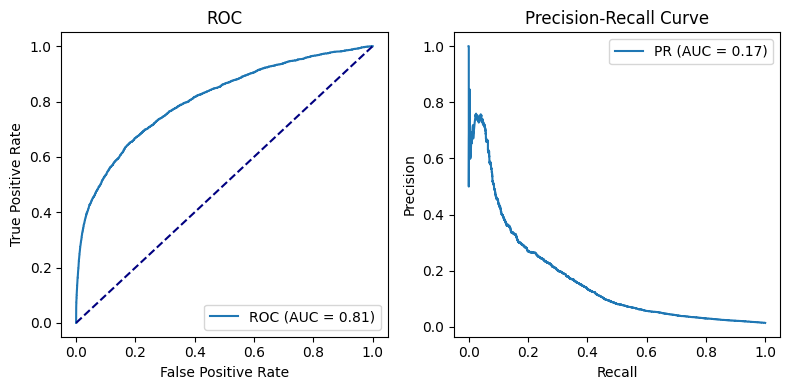

In [47]:
y_pred_prob2 = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob2)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob2)

plt.figure(figsize=(8, 4))

# Curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# Curva de precisión-recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

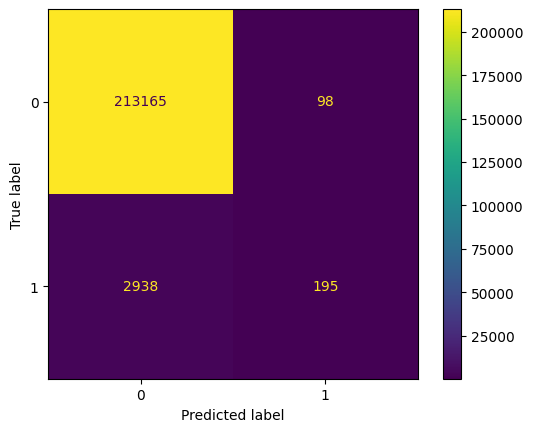

In [48]:
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test)

El Best_model (c=0.1, reg=l1) es inlcuso mejor en test. El Area under the curve pasa a ser .81 y la precision un 66% con un threshold default del 50%. Si finalmente se considera muy gravoso enviar muchas notificaciones a pesar de no tener claro si el cliente comprara o no, es un buen modelo. Por ultimo entrenaremos el modelo (c=0.1, reg=l1) con toda la bdd y lo compararemos con un baseline

# Final model

In [44]:
X = frequency_encoding(X, 'vendor')
X = sc.fit_transform(X)

pipe = Pipeline([
    ('classifier', LogisticRegression(random_state=42, solver='saga'))
])

# Paso 2: Definimos parámetros (elasticnet es una combinacion de Lasso + Ridege, siendo Lasso l1 y Ridge l2)
param_grid = {
    'classifier__penalty': ['l1'],
    'classifier__C': [0.1]
}

# Paso 3: GridSearch con scoring 'accuracy' de la matriz de confusion
final_grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs = -1, scoring='accuracy')
final_grid_search.fit(X, y)

/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1], 'classifier__penalty': ['l1']},
             scoring='accuracy')

In [47]:
#save your model or results
joblib.dump(final_grid_search, 'final_model_file.pkl')
#load your model for further usage
#grid_search = joblib.load("model_file.pkl")

['final_model_file.pkl']

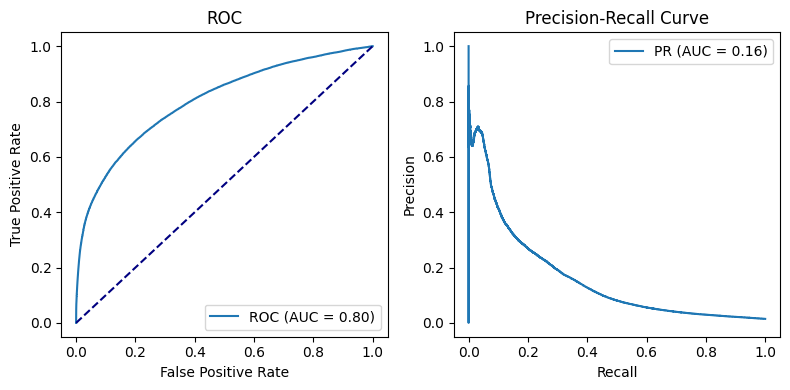

In [45]:
y_pred_prob6 = grid_search.predict_proba(X)[:, 1]
fpr, tpr, _ = roc_curve(y, y_pred_prob6)
precision, recall, _ = precision_recall_curve(y, y_pred_prob6)

plt.figure(figsize=(8, 4))

# Curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# Curva de precisión-recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

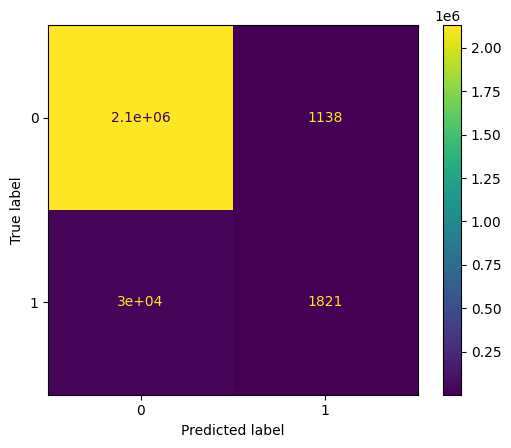

In [46]:
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X, y)

El modelo pierde precision para thesholds altos (ahora para el del 50% la rpecision es un 60%) pero gana en thresholds bajos. No parece haber overfitting en el proceso, pero el desbalanceo sigue afectando.

Como baselines, podemos utilizar directametne ordered_before (ya que esta codificada como 0, 1) y un segundo baseline global_popularity, estableciendo como caso positivo los items con popularidad > 3 (por encima del tercer cuartil)

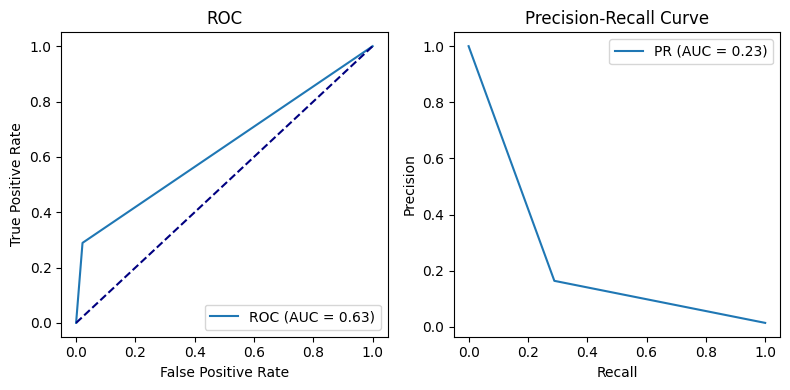

In [41]:
fpr, tpr, _ = roc_curve(y, X['ordered_before'])
precision, recall, _ = precision_recall_curve(y, X['ordered_before'])

plt.figure(figsize=(8, 4))

# Curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# Curva de precisión-recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

Este baseline es parecido a nuestro solo para los tramos de la curva que mas penalizan a los falsos negativos, para el resto es mejor nuestro modelo.

In [42]:
X[['global_popularity']].describe()

,global_popularity
count,2.163953e+06
mean,1.078504e-02
std,1.663036e-02
min,0.000000e+00
25%,1.633987e-03
50%,6.342495e-03
75%,1.432881e-02
max,4.254386e-01


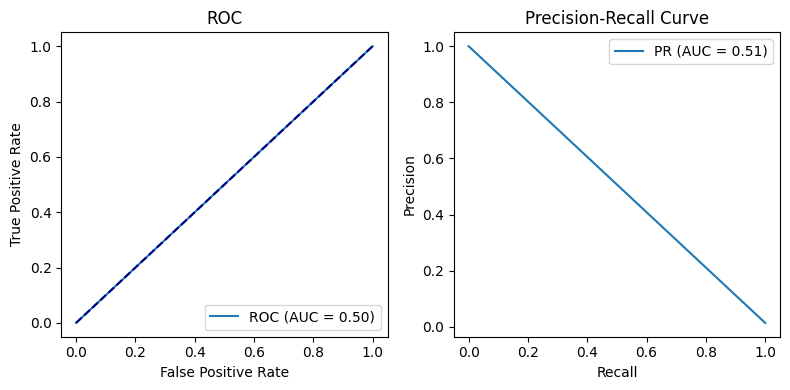

In [43]:
pop = X['global_popularity'].values
baseline = np.where(pop > 4, 1, 0)

fpr, tpr, _ = roc_curve(y, baseline)
precision, recall, _ = precision_recall_curve(y, baseline)

plt.figure(figsize=(8, 4))

# Curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# Curva de precisión-recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

Este benchmark no resulta util para predecir si compra o no, es directamente aleatorio